In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import GridSearchCV, cross_val_score
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.decomposition import PCA
from torch.utils.data import TensorDataset, DataLoader

In [15]:
data = pd.read_csv("./train.csv")
X = data.iloc[:, 6:]
classifiers = data.iloc[:, 1:4]
enc = OneHotEncoder()
data_oh = enc.fit_transform(classifiers).toarray()
data_oh = pd.DataFrame(data_oh)
X = pd.concat([data_oh, X], axis=1)
X


,0,1,2,3,4,5,6,7,8,9,...,1620.5,1626.6,1632.8,1639,1645.2,1651.4,1657.6,1663.8,1670,1676.2
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.003972,0.007906,0.012490,0.018123,0.025070,0.033235,0.042502,0.052237,0.061383,0.068823
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.093002,0.099668,0.108805,0.117120,0.121947,0.125137,0.128688,0.133501,0.138187,0.140248
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.083369,0.090485,0.100462,0.109033,0.113411,0.117053,0.121665,0.128366,0.134636,0.136961
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.357223,0.370060,0.386062,0.404460,0.425567,0.450527,0.479066,0.508943,0.539349,0.564486
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.350973,0.366094,0.384536,0.405034,0.426582,0.450564,0.477045,0.504142,0.531764,0.553650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.133917,0.138535,0.145144,0.151008,0.153738,0.155602,0.158525,0.163138,0.167623,0.169048
1296,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.007995,-0.004902,-0.001237,0.003390,0.009303,0.016472,0.023843,0.031736,0.039568,0.046056
1297,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.052178,0.056051,0.060666,0.066257,0.073435,0.083057,0.094621,0.106288,0.117307,0.126626
1298,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.094620,0.101527,0.111090,0.119861,0.124868,0.128340,0.132605,0.138737,0.144825,0.148246


In [17]:
#spectrum_filtered = pd.DataFrame(savgol_filter(spectrum, 7, 3, deriv = 2, axis = 0))
#spectrum_filtered_st = zscore(spectrum_filtered, axis = 1)

y = data["PURITY"]/100
print(y)

X.columns = X.columns.astype(str)

pca = PCA(n_components=16)
X_pca = pca.fit_transform(X)
print(pca.explained_variance_ratio_)

X_train, X_valid, y_train, y_valid = train_test_split(X_pca, y, test_size=0.2, random_state=42)

standardizer = StandardScaler()
X_train_standardized = standardizer.fit_transform(X_train)
X_valid_standardized = standardizer.transform(X_valid)

# Convert to tensors
X_train_tensor = torch.tensor(X_train_standardized, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
X_valid_tensor = torch.tensor(X_valid_standardized, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid.values, dtype=torch.float32).reshape(-1, 1)

0       0.585000
1       0.186000
2       0.198817
3       0.525000
4       0.489000
          ...   
1295    0.101000
1296    0.449000
1297    0.534000
1298    0.136000
1299    0.196000
Name: PURITY, Length: 1300, dtype: float64
[0.41552838 0.16514037 0.11152638 0.05714211 0.04971209 0.03813631
 0.03480404 0.02064408 0.01245043 0.00957444 0.00776663 0.0058306
 0.00564614 0.00517384 0.00510526 0.00369527]


In [18]:
# Définir le modèle de réseau de neurones simple
class SimpleNN(nn.Module):
    def __init__(self, input_size, fc1_out_features=50, fc2_out_features=1, dropout_rate=0.2):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, fc1_out_features)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(fc1_out_features, fc2_out_features)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(fc2_out_features, 1)
    
    def forward(self, x):
        x = F.silu(self.fc1(x))
        x = self.dropout1(x)
        x = F.silu(self.fc2(x))
        x = self.dropout2(x)
        x = F.sigmoid(self.fc3(x))
        return x

# Définir la classe NeuralNetRegressor
class NeuralNetRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, input_size, eta=0.001, max_epochs=100, fc1_out_features=50, fc2_out_features=1, batch=10, dropout_rate = 0.5):
        self.input_size = input_size
        self.eta = eta
        self.max_epochs = max_epochs
        self.fc1_out_features = fc1_out_features
        self.fc2_out_features = fc2_out_features
        self.batch = batch
        self.dropout_rate = dropout_rate
        self.model = SimpleNN(input_size, fc1_out_features, fc2_out_features)
        self.criterion = nn.MSELoss()
    
    def fit(self, X, y, do_print=False):
        optimizer = optim.Adam(self.model.parameters(), lr=self.eta)
        X_tensor = torch.tensor(X).clone().detach().float()
        y_tensor = torch.tensor(y).clone().detach().float()
        dataset = TensorDataset(X_tensor, y_tensor)
        dataloader = DataLoader(dataset, batch_size=self.batch, shuffle=True)
        self.model.train()
        # Training loop
        for epoch in range(self.max_epochs):
            epoch_loss = 0.0
            for batch_X, batch_y in dataloader:
                optimizer.zero_grad()  # Reset gradients
                outputs = self.model(batch_X)  # Forward pass
                loss = self.criterion(outputs, batch_y)  # Compute loss
                loss.backward()  # Backward pass
                optimizer.step()  # Update parameters
                epoch_loss += loss.item()
            if do_print:
                print(f"Epoch {epoch+1}/{self.max_epochs}, Loss: {epoch_loss / len(dataloader)}")
        return self
    
    def predict(self, X):
        self.model.eval()
        X_tensor = torch.tensor(X, dtype=torch.float32)
        with torch.no_grad():
            outputs = self.model(X_tensor).flatten()
        return outputs.numpy()
    
    def parameters(self):
        return self.model.parameters()

# Initialiser le modèle
input_size = X_train_tensor.shape[1]
net = NeuralNetRegressor(input_size=input_size)

# Définir les paramètres pour GridSearch
params = {
    'eta': [0.0005, 0.001],
    'max_epochs': [50],
    'fc1_out_features': [32, 64, 128],
    'fc2_out_features': [32, 64, 128],
    'batch': [65, 70],
    'dropout_rate': [0.3, 0.4, 0.5]
}

# Initialiser GridSearchCV
grid_search = GridSearchCV(net, params, refit=True, cv=5, scoring='neg_mean_squared_error', verbose=0)

# Entraîner le modèle avec GridSearch
grid_result = grid_search.fit(X_train_tensor, y_train_tensor)
nouveau_model = grid_result.best_estimator_

print("Best MSE: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


/var/folders/93/xgf_b79s5sd1vjn_794f14ym0000gn/T/ipykernel_1118/3960602896.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X).clone().detach().float()
/var/folders/93/xgf_b79s5sd1vjn_794f14ym0000gn/T/ipykernel_1118/3960602896.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).clone().detach().float()
/var/folders/93/xgf_b79s5sd1vjn_794f14ym0000gn/T/ipykernel_1118/3960602896.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float32)
/var/fol

KeyboardInterrupt: 

X_valid_tensor contains NaN: False
y_valid_tensor contains NaN: False
y_pred contains NaN: False
MSE : 0.0055522863
t_score test : 1.0
t_score train : 1.0


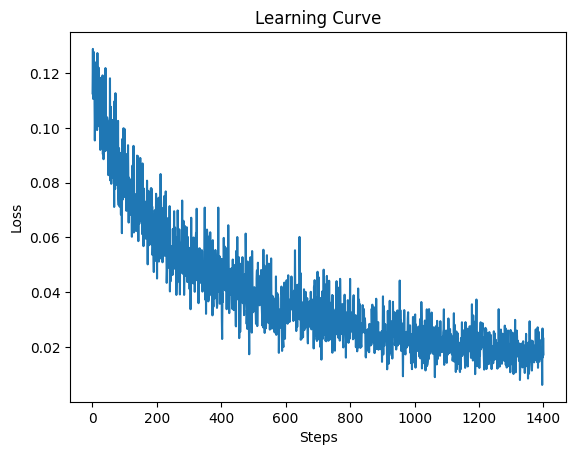

In [ ]:
y_pred = nouveau_model.predict(X_valid_tensor)
y_pred_train=nouveau_model.predict(X_train_tensor)

# Vérifiez les sorties du modèle
print("y_pred contains NaN:", np.isnan(y_pred).any())

# Calculer la MSE
mse = np.mean(((y_pred - y_valid)*100)**2)
print("MSE :", mse)

# Calculer le t_score
train_score = np.mean(np.abs((y_pred_train-y_train)*100<=5))
test_score = np.mean(np.abs((y_pred-y_valid)*100<=5))
print("t_score test :", train_score)
print("t_score train :", test_score)

"""
# Afficher la courbe d'apprentissage
import matplotlib.pyplot as plt
plt.plot(steps, learning_curve)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.show()
"""